In [1]:
import warnings

warnings.filterwarnings('ignore')

               value
2020-01-01  0.248357
2020-01-02 -0.053354
2020-01-03  0.355397
2020-01-04  0.808834
2020-01-05 -0.054003
...              ...
2020-07-14  0.257322
2020-07-15 -0.393019
2020-07-16  0.110007
2020-07-17  0.046475
2020-07-18 -0.569892

[200 rows x 1 columns]


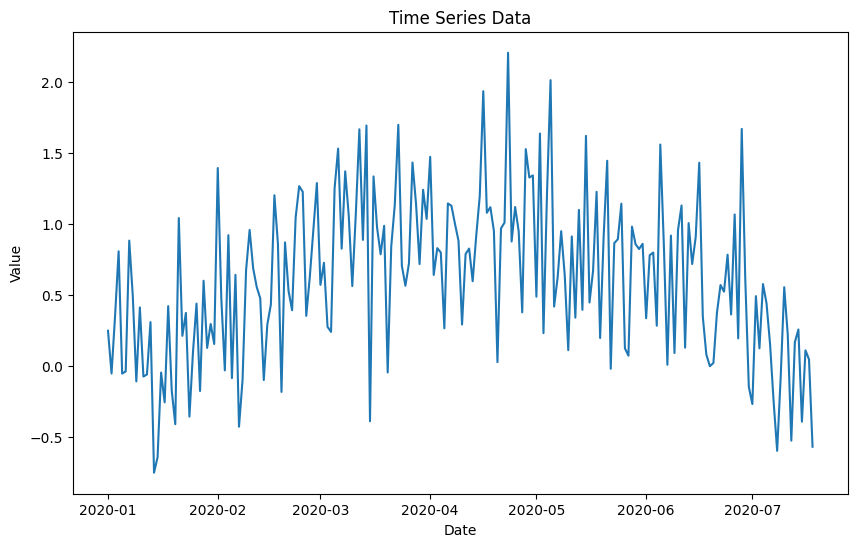

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 예시 데이터 생성 (임의의 일변량 시계열 데이터)
np.random.seed(42)
date_range = pd.date_range(start='1/1/2020', periods=200, freq='D')
data = np.sin(np.linspace(0, 3.14, 200)) + np.random.normal(scale=0.5, size=200)
time_series_data = pd.DataFrame(data, index=date_range, columns=['value'])

print(time_series_data)

# 데이터 시각화
plt.figure(figsize=(10, 6))
plt.plot(time_series_data)
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [3]:
# LSTM 모델에 입력될 데이터 형식 준비
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

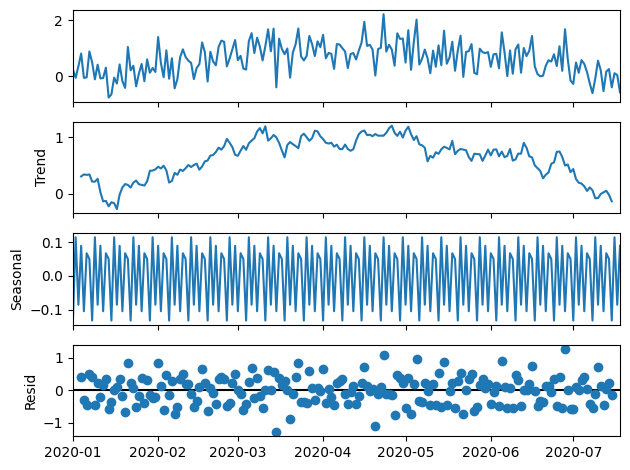

In [4]:
# 시계열 분해
result = seasonal_decompose(time_series_data, model='additive')
result.plot()
plt.show()

# 데이터 전처리: MinMax Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series_data)

In [5]:
time_step = 10
X, Y = create_dataset(scaled_data, time_step)

# 데이터 차원 변경: [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# LSTM 모델 구축
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 모델 학습
model.fit(X, Y, epochs=300, batch_size=1, verbose=1)

Epoch 1/300
189/189 [==============================] - 2s 3ms/step - loss: 0.0368
Epoch 2/300
189/189 [==============================] - 0s 2ms/step - loss: 0.0320
Epoch 3/300
189/189 [==============================] - 0s 3ms/step - loss: 0.0311
Epoch 4/300
189/189 [==============================] - 0s 2ms/step - loss: 0.0309
Epoch 5/300
189/189 [==============================] - 0s 2ms/step - loss: 0.0331
Epoch 6/300
189/189 [==============================] - 0s 2ms/step - loss: 0.0303
Epoch 7/300
189/189 [==============================] - 0s 2ms/step - loss: 0.0323
Epoch 8/300
189/189 [==============================] - 0s 2ms/step - loss: 0.0295
Epoch 9/300
189/189 [==============================] - 0s 2ms/step - loss: 0.0295
Epoch 10/300
189/189 [==============================] - 0s 2ms/step - loss: 0.0299
Epoch 11/300
189/189 [==============================] - 0s 2ms/step - loss: 0.0307
Epoch 12/300
189/189 [==============================] - 0s 2ms/step - loss: 0.0305
Epoch 13/300


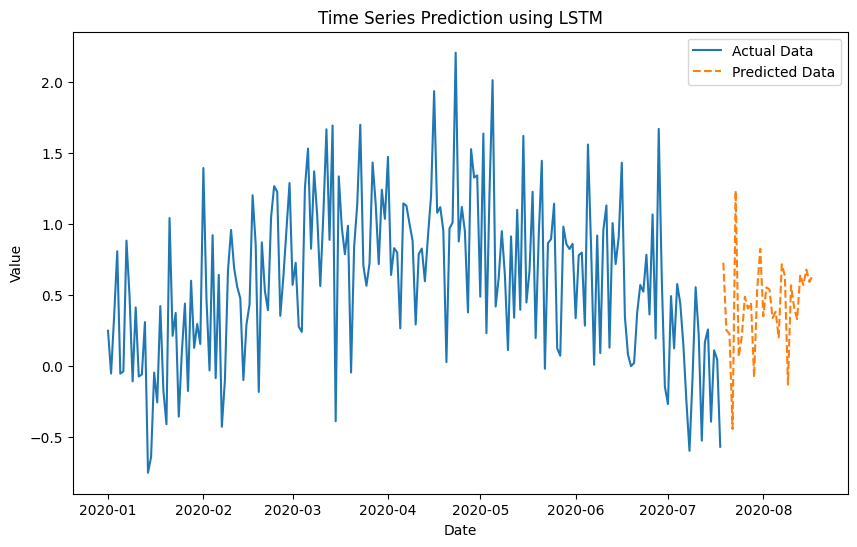

In [6]:
# 미래 데이터 예측
pred_count = 30  # 예측할 미래 시간대의 수
input_seq = scaled_data[-time_step:]  # 가장 최근의 입력 시퀀스
predictions = []

for _ in range(pred_count):
    input_seq = input_seq.reshape((1, time_step, 1))
    predicted_value = model.predict(input_seq, verbose=0)
    predictions.append(predicted_value[0, 0])
    input_seq = np.append(input_seq[:, 1:, :], predicted_value.reshape(1, 1, 1), axis=1)

# 원래 스케일로 되돌리기
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# 예측 결과 시각화
future_dates = pd.date_range(start=time_series_data.index[-1] + pd.Timedelta(days=1), periods=pred_count, freq='D')
predicted_series = pd.DataFrame(predictions, index=future_dates, columns=['value'])

plt.figure(figsize=(10, 6))
plt.plot(time_series_data, label='Actual Data')
plt.plot(predicted_series, label='Predicted Data', linestyle='--')
plt.title('Time Series Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()